In [2]:
!pip install split-folders



In [3]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms as transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import splitfolders

In [4]:
input_folder = '/kaggle/input/flower-data/train-20240314T173053Z-001/train'  # Path to your input data folder

splitfolders.ratio(input_folder, ratio=(0.8, 0.2))

Copying files: 2746 files [00:24, 114.21 files/s]


In [5]:
# Define transformations for data preprocessing
# Define data transformations for data augmentation and normalization
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [7]:
data_dir = '/kaggle/working/output'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 2194, 'val': 552}


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

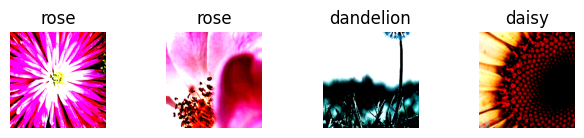

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Get a batch of data from the train_loader
dataiter = next(iter(dataloaders['train']))
images, labels = dataiter

for i in range(min(16, len(images))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().transpose(1, 2, 0))
    plt.title(class_names[labels[i].item()])
    plt.axis('off')

plt.tight_layout()
plt.show()
        


In [8]:
for label in labels:
    print(label)

tensor(3)
tensor(4)
tensor(2)
tensor(1)


In [31]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 5)  # Assuming 5 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the MLP model
#model = MLP()




In [10]:
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s] 


In [14]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.7823 Acc: 0.7402
val Loss: 0.3660 Acc: 0.8768
train Loss: 0.7755 Acc: 0.7375
val Loss: 0.3349 Acc: 0.8949
train Loss: 0.7609 Acc: 0.7452
val Loss: 0.3789 Acc: 0.8804
train Loss: 0.7626 Acc: 0.7397
val Loss: 0.4194 Acc: 0.8696
train Loss: 0.7983 Acc: 0.7347
val Loss: 0.3652 Acc: 0.8768
train Loss: 0.7171 Acc: 0.7461
val Loss: 0.3763 Acc: 0.8822
train Loss: 0.7842 Acc: 0.7434
val Loss: 0.3946 Acc: 0.8841
train Loss: 0.7447 Acc: 0.7584
val Loss: 0.3504 Acc: 0.8877
train Loss: 0.7301 Acc: 0.7493
val Loss: 0.4180 Acc: 0.8786
train Loss: 0.6741 Acc: 0.7571
val Loss: 0.3488 Acc: 0.8859
Training complete!


In [15]:
# Save the model
torch.save(model.state_dict(), 'flower_classification_model.pth')






In [16]:
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 5)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [18]:
# Load and preprocess the unseen image
image_path = '/kaggle/input/flower-data/test-20240314T191659Z-001/test/Image_1.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [19]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion','rose','sunflower','tulip']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: sunflower


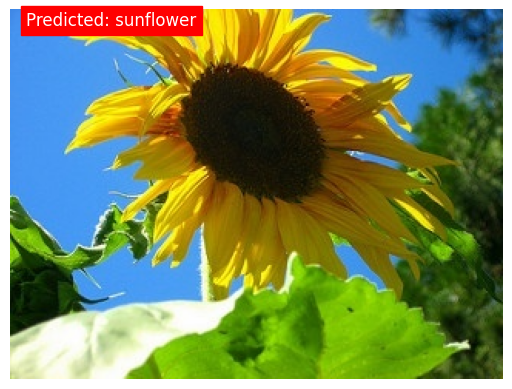

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()